In [1]:
import numpy as np
import pandas as pd
from scipy.stats import truncnorm
import matplotlib.pyplot as plt

In [2]:
# Inputs
contact_rate = 1.0
recovery_rate = 0.1
total_pop = 1000
inf_init = 12
n_particles = 100
observations = [0, 15, 40, 65, 124, 204, 252, 210]

# Updating particles
def update_particles(particles, contact_rate, recovery_rate, total_pop):
    suscept, infect, recovered = np.copy(particles[:, 0]), np.copy(particles[:, 1]), np.copy(particles[:, 2])
    new_infections = np.random.binomial(suscept.astype(int), 1.0 - np.exp(-contact_rate * infect / total_pop))
    new_recoveries = np.random.binomial(infect.astype(int), 1.0 - np.exp(-recovery_rate))
    suscept -= new_infections
    infect += new_infections - new_recoveries
    recovered += new_recoveries
    updated_particles = np.vstack([suscept, infect, recovered]).T  # Join the outputs as the columns of the new array
    return updated_particles

# Calculation of importance weights
target_sd = 50.0
def get_importance(p_vals, mean):
    zero_trunc_vals = -p_vals / target_sd
    target = np.array([mean] * n_particles)
    return truncnorm.pdf(target, zero_trunc_vals, np.inf, loc=p_vals, scale=target_sd)

def get_counts_df_from_particles(particles):
    melted_df = pd.DataFrame(particles).melt(var_name="Columns", value_name="Values")
    return melted_df.groupby(["Columns", "Values"]).size().reset_index(name="Counts")

# Plot results for number of infectious from output array
def plot_particle_results(prop_particles, resamp_particles):
    prop_counts = get_counts_df_from_particles(prop_particles[:, 1, :])
    resamp_counts = get_counts_df_from_particles(resamp_particles[:, 1, :])
    results_plot = plt.scatter(prop_counts["Columns"] - 0.2, prop_counts["Values"], s=prop_counts["Counts"] * 15.0, alpha=0.5, label="proposed")
    plt.scatter(resamp_counts["Columns"], resamp_counts["Values"], s=resamp_counts["Counts"] * 15.0, alpha=0.5, label="resampled")
    plt.scatter(range(1, len(observations) + 1), observations, label="target")
    plt.legend()
    return results_plot

In [3]:
# Initialise particles
particles = np.zeros([n_particles, 3, len(observations) + 1])
particles[:, 0, 0] = total_pop - inf_init
particles[:, 1, 0] = inf_init
particles[:, 2, 0] = 0
prop_particles = np.copy(particles)

# Main loop
for o, obs in enumerate(observations):
    
    # Prediction
    proposed_particles = update_particles(particles[:, :, o], contact_rate, recovery_rate, total_pop)
    prop_particles[:, :, o + 1] = proposed_particles

    # Importance
    weights = get_importance(proposed_particles[:, 1], obs)
    norm_weights = weights / sum(weights)

    # Resampling
    indices = np.random.choice(range(n_particles), size=n_particles, p=norm_weights)
    resamp_particles = proposed_particles[indices]
    
    # Update
    particles[:, :, o + 1] = resamp_particles

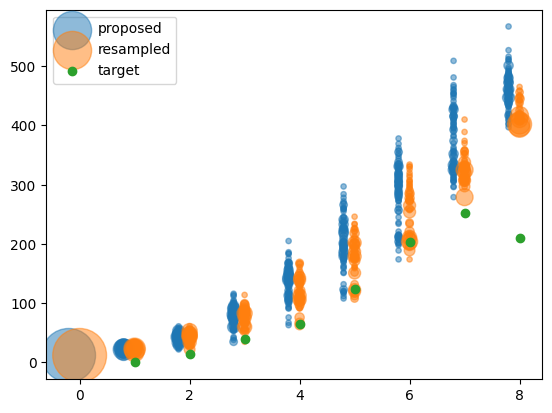

In [4]:
plot_particle_results(prop_particles, particles)